In [103]:
import os
import scipy.stats as stats
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import squarify


pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 0) 


def calculate_confidence_interval(values, confidence=0.95):
    """
    Calculate confidence interval for a series of values.
    
    Args:
        values: pandas Series or list of values
        confidence: confidence level (default 0.95 for 95% CI)
    
    Returns:
        tuple: (mean, lower_bound, upper_bound, margin_of_error)
    """
    n = len(values)
    mean = np.mean(values)
    std_err = stats.sem(values)  # Standard error of the mean
    
    # Calculate margin of error using t-distribution
    t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    margin_of_error = t_value * std_err
    
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    
    return mean, lower_bound, upper_bound, margin_of_error

    

Data dictionary:

Dataset contains set of metric:  

Columns with Answer Similarity:  
* "Answer Semantic Similarity for vanilla"   
* "Answer Semantic Similarity for rag" 

Columns with Answer Relevancy (calculate mean for final result):  
* "answer_relevancy for Vanilla run 1"  
* "answer_relevancy for Vanilla run 2"     
* "answer_relevancy for Vanilla run 3"     
* "answer_relevancy for RAG run 1"   
* "answer_relevancy for RAG run 2"     
* "answer_relevancy for RAG run 3"  

Columns with rubric score (adapted Likert scale from 1 to 5):  
* "Vanilla Rubric Score"   
* "RAG Rubric Score"  

Columns with RAG specific metrics:  

Faithfulness  
* "faithfulness for RAG run 1"   
* "faithfulness for RAG run 2"     
* "faithfulness for RAG run 3" 

Context precission  
* "context_precision for RAG run 1"   
* "context_precision for RAG run 2"   
* "context_precision for RAG run 3"  

Context recall

 



Questions by categories:
* Other Mental Disorders                                  114  
* Depressive Disorders                                     62  
* Schizophrenia Spectrum and Other Psychotic Disorders     57  
* Bipolar Disorders                                        33  
* Trauma and Stressor Related Disorders                    24  
* Personality Disorders                                    23  
* Anxiety Disorders                                        22  
* Eating Disorders                                         13  
* Somatic Disorders                                        10  
* Obsessive-Compulsive Disorders                           10  
* Dissociative Disorders                                    1  

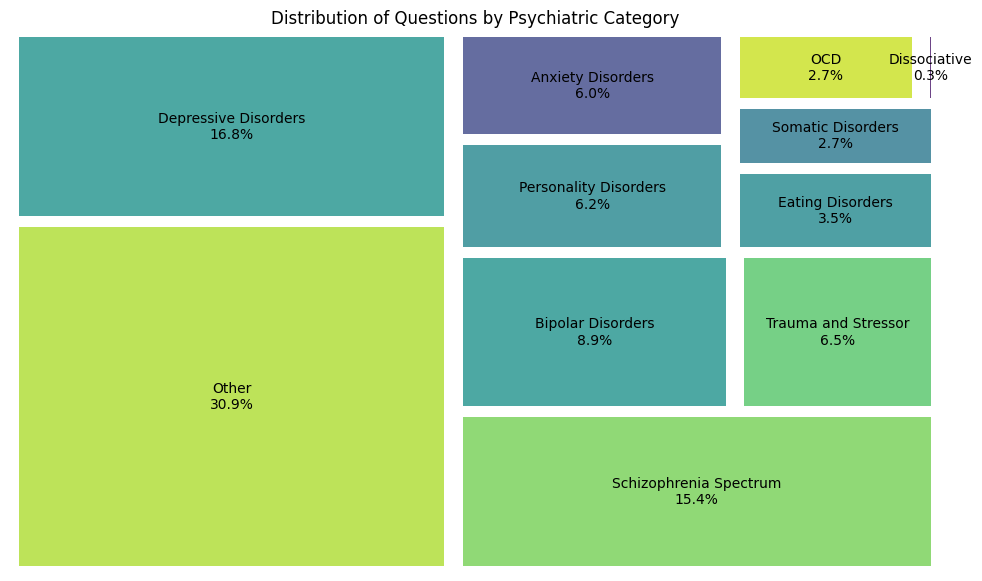

In [104]:
# Read data
with open("advanced_rag/results/DeepSeek V3.json", "r", encoding="utf-8") as f:
    data = json.load(f)
df = pd.DataFrame(data)

# Shorten category names
category_rename = {
    "Schizophrenia Spectrum and Other Psychotic Disorders": "Schizophrenia Spectrum",
    "Trauma and Stressor Related Disorders": "Trauma and Stressor",
    "Obsessive-Compulsive Disorders": "OCD",
    "Other Mental Disorders": "Other",
    "Dissociative Disorders": "Dissociative"
}
df['psychiatric_category'] = df['psychiatric_category'].replace(category_rename)

# Count questions per category
cat_counts = df['psychiatric_category'].value_counts()



# Calculate percentages
total = cat_counts.sum()
percentages = cat_counts / total * 100

# Prepare labels with category and percentage
labels = [f"{cat}\n{pct:.1f}%" for cat, pct in zip(cat_counts.index, percentages)]

# Plot treemap
plt.figure(figsize=(12, 7))
squarify.plot(sizes=cat_counts.values, label=labels, alpha=0.8, pad=True)
plt.axis('off')
plt.title("Distribution of Questions by Psychiatric Category")
plt.show()

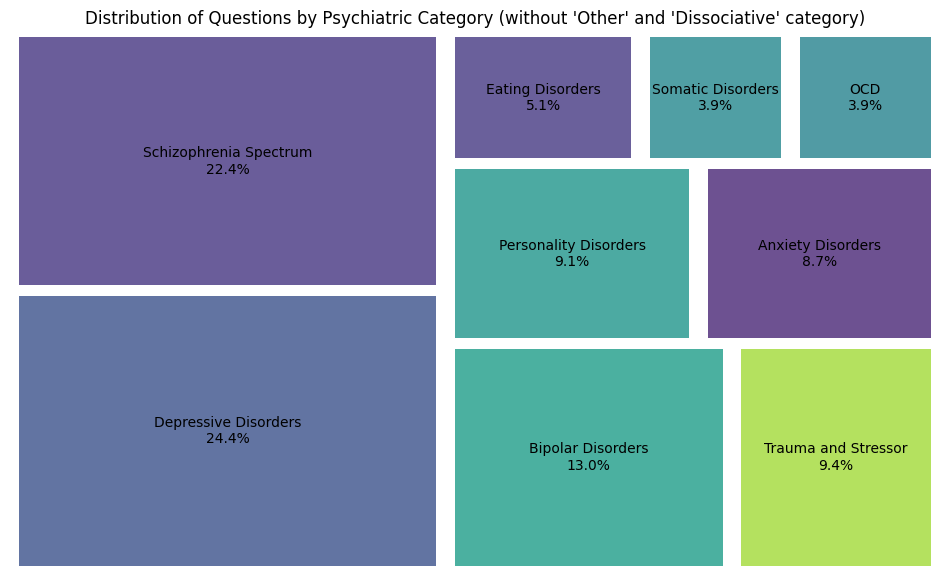

In [105]:
# Count questions per category
cat_counts = df['psychiatric_category'].value_counts()

# Remove "Other" and "Dissociative"
cat_counts = cat_counts.drop(["Other", "Dissociative"], errors="ignore")

# Calculate percentages
total = cat_counts.sum()
percentages = cat_counts / total * 100

# Prepare labels with category and percentage
labels = [f"{cat}\n{pct:.1f}%" for cat, pct in zip(cat_counts.index, percentages)]

# Plot treemap
plt.figure(figsize=(12, 7))
squarify.plot(sizes=cat_counts.values, label=labels, alpha=0.8, pad=True)
plt.axis('off')
plt.title("Distribution of Questions by Psychiatric Category (without 'Other' and 'Dissociative' category)")
plt.show()

At the first step, we compare overall model performance for answer similarity, answer relevancy, and rubric score. 

In [106]:
def compare_overall_answer_similarity_all_models(folder_path):
    results = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            # Extract similarities
            df = df.dropna(subset=['Answer Semantic Similarity for vanilla', 'Answer Semantic Similarity for rag'])
            vanilla_similarity = df['Answer Semantic Similarity for vanilla'].astype(float).values
            rag_similarity = df['Answer Semantic Similarity for rag'].astype(float).values
            # Calculate confidence intervals
            vanilla_cat_ci = calculate_confidence_interval(vanilla_similarity)
            rag_cat_ci = calculate_confidence_interval(rag_similarity)
            # Paired t-test
            t_stat, p_value = stats.ttest_rel(rag_similarity, vanilla_similarity)
            results.append({
                'Model': filename.replace('.json', ''),
                'Vanilla Mean Similarity': vanilla_cat_ci[0],
                'Vanilla 95% CI': f"[{vanilla_cat_ci[1]:.4f} - {vanilla_cat_ci[2]:.4f}]",
                'RAG Mean Similarity': rag_cat_ci[0],
                'RAG 95% CI': f"[{rag_cat_ci[1]:.4f} - {rag_cat_ci[2]:.4f}]",
                'Difference': rag_cat_ci[0] - vanilla_cat_ci[0],
                'P Value': p_value,
                'N Vanilla': len(vanilla_similarity),
                'N RAG': len(rag_similarity),
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    # Output results
    drop_cols = ['N Vanilla', 'N RAG']
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('Difference', ascending=False)
        results_df['P Value'] = results_df['P Value'].apply(lambda x: f"{x:.4f}")
        results_df = results_df.drop(columns=[col for col in drop_cols if col in results_df.columns])
        print("Overall Answer Similarity Results:")
        display(results_df.reset_index(drop=True))



## RAGAS Answer semantic similarity  

This evaluation is based on the ground truth and the answer, with values falling within the range of 0 to 1. A higher score signifies a better alignment 
between the generated answer and the ground truth.  
Step 1: Vectorize the ground truth answer using the specified embedding model.  
Step 2: Vectorize the generated answer using the same embedding model.  
Step 3: Compute the cosine similarity between the two vectors.  

The metric is a part of RAGAS Answer Correctness metric. The Answer Correctness's final score is created by taking a weighted average of the factual correctness (F1 score) and the semantic similarity. 
(By default, there is a 0.75 : 0.25 weighting.)   


Total API Calls: 2
* 1 embedding call to embed the ground truth
* 1 embedding call to embed the AI answer  

Since the output is deterministic, we run evaluation only once for each question.   

Sources:  
* [Ragas Docs for semantic similarity](https://docs.ragas.io/en/v0.1.21/concepts/metrics/semantic_similarity.html)   
* https://github.com/dkhundley/llm-rag-guide/blob/main/notebooks/ragas.ipynb

In [107]:
compare_overall_answer_similarity_all_models("advanced_rag/results")  

Overall Answer Similarity Results:


,Model,Vanilla Mean Similarity,Vanilla 95% CI,RAG Mean Similarity,RAG 95% CI,Difference,P Value,Significant
0,DeepSeek V3,0.869639,[0.8645 - 0.8748],0.870540,[0.8655 - 0.8755],0.000901,0.5787,No
1,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.877589,[0.8727 - 0.8825],0.876692,[0.8718 - 0.8815],-0.000897,0.5361,No
2,LG AI ExaOne 3.5 32B Instruct,0.870511,[0.8655 - 0.8756],0.868780,[0.8638 - 0.8738],-0.001730,0.3237,No
3,Meta Llama 4 Scout 17B-16E Instruct,0.879409,[0.8747 - 0.8842],0.875244,[0.8700 - 0.8805],-0.004164,0.0144,Yes
4,Google Gemma 3n E4B-it,0.867605,[0.8624 - 0.8728],0.862620,[0.8572 - 0.8680],-0.004985,0.0192,Yes
5,Qwen 2.5-72B-Instruct-Turbo,0.883301,[0.8784 - 0.8882],0.876282,[0.8711 - 0.8814],-0.007019,0.0000,Yes
6,Meta Llama 3.2 3B Instruct Turbo,0.862190,[0.8558 - 0.8686],0.854541,[0.8487 - 0.8604],-0.007649,0.0122,Yes
7,Mistral Small 24B Instruct-2501,0.879610,[0.8746 - 0.8846],0.869777,[0.8645 - 0.8750],-0.009833,0.0000,Yes
8,Meta Llama 3.1 8B Instruct Turbo,0.872187,[0.8670 - 0.8773],0.859259,[0.8541 - 0.8644],-0.012928,0.0000,Yes
9,Qwen3 235B-A22B-fp8,0.854811,[0.8502 - 0.8594],0.834919,[0.8299 - 0.8400],-0.019892,0.0000,Yes


In 7 out of 10 models, RAG does not improve and often reduces answer similarity to compared to vanilla models.   

* The only model that have slight increase of metric is DeepSeekV3. The difference is not statistically significant.   

In [108]:
def plot_answer_similarity_all_models(folder_path, category=None):
    results = []
    
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            if category is not None:
                df = df[df['psychiatric_category'] == category]
            vanilla_similarity = df['Answer Semantic Similarity for vanilla'].astype(float).mean()
            rag_similarity = df['Answer Semantic Similarity for rag'].astype(float).mean()
            results.append({
                'Model': filename.replace('.json', ''),
                'Vanilla Similarity': vanilla_similarity,
                'RAG Similarity': rag_similarity
            })
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    results_df = pd.DataFrame(results)
    results_df.set_index('Model', inplace=True)
    
    short_names = {
    "DeepSeek V3": "DeepSeekV3",
    "Google Gemma 3n E4B-it": "Gemma3B",
    "LG AI ExaOne 3.5 32B Instruct": "Exaone 32B",
    "Meta Llama 3.1 8B Instruct Turbo": "Llama3.1-8B",
    "Meta Llama 4 Maverick 17B-128E-Instruct-FP8": "Llama4-Maverick",
    "Meta Llama 4 Scout 17B-16E Instruct": "Llama4-Scout",
    "Mistral Small 24B Instruct-2501": "Mistral 24B",
    "Qwen 2.5-72B-Instruct-Turbo": "Qwen2.5-72B",
    "Qwen3 235B-A22B-fp8": "Qwen3",
    "Meta Llama 3.2 3B Instruct Turbo": "Llama3.2-3B-Turbo",

    
    
}

    # Replace model names in the DataFrame for plotting
    results_df_plot = results_df.copy()
    results_df_plot['Short Model'] = results_df_plot.index.map(lambda x: short_names.get(x, x))

    title = f'Answer Similarity Scores for All Models'

    plt.figure(figsize=(10, 6))
    plt.plot(results_df_plot['Short Model'], results_df_plot['Vanilla Similarity'], marker='o', label='Vanilla Similarity')
    plt.plot(results_df_plot['Short Model'], results_df_plot['RAG Similarity'], marker='o', label='RAG Similarity')
    if category:
        title += f" ({category})"
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Similarity Score')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

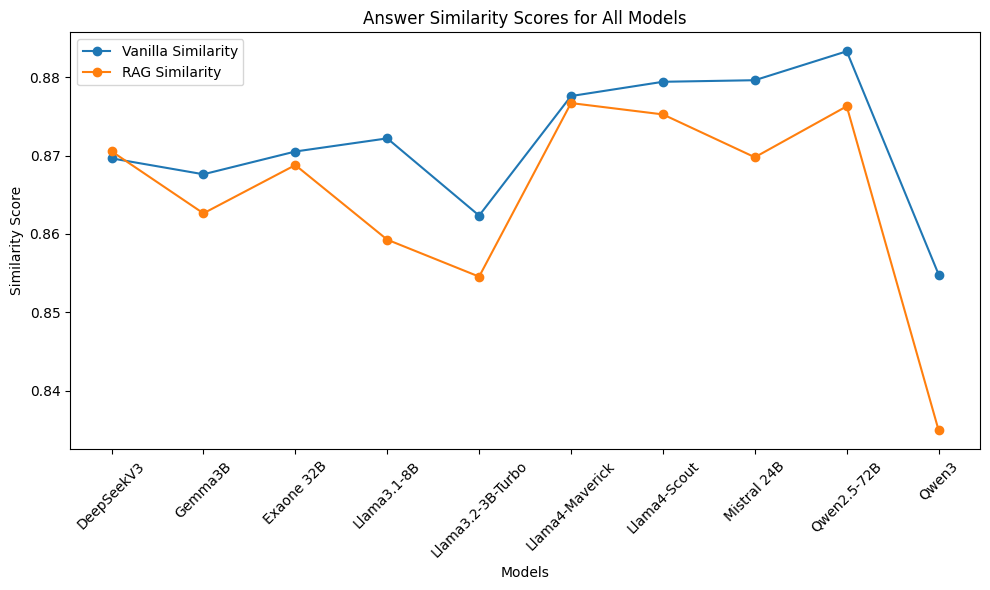

In [109]:
plot_answer_similarity_all_models("advanced_rag/results")

In [110]:
categories_full = ['Depressive Disorders',
            'Somatic Disorders', 
            'Anxiety Disorders',
            'Other Mental Disorders',
            'Bipolar Disorders',
            'Schizophrenia Spectrum and Other Psychotic Disorders',
            'Trauma and Stressor Related Disorders',
            'Personality Disorders',
            'Obsessive-Compulsive Disorders',
            'Eating Disorders',
            'Dissociative Disorders']  

categories = ['Depressive Disorders',
            ]  



def compare_similarity_by_category(folder_path, categories):

    
    for category in categories:
        results = []
        for filename in os.listdir(folder_path):
            if not filename.endswith('.json'):
                continue
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                df = pd.DataFrame(data)
                df = df[df['psychiatric_category'] == category]
                df = df.dropna(subset=['Answer Semantic Similarity for vanilla', 'Answer Semantic Similarity for rag'])
                # Extract similarities
                vanilla_similarity = df['Answer Semantic Similarity for vanilla'].astype(float).values
                rag_similarity = df['Answer Semantic Similarity for rag'].astype(float).values
                # Calculate confidence intervals
                if len(vanilla_similarity) > 1 and len(rag_similarity) > 1 and len(vanilla_similarity) == len(rag_similarity):
                    vanilla_cat_ci = calculate_confidence_interval(vanilla_similarity)
                    rag_cat_ci = calculate_confidence_interval(rag_similarity)
                    # Paired t-test
                    t_stat, p_value = stats.ttest_rel(rag_similarity, vanilla_similarity)
                    results.append({
                        'Model': filename.replace('.json', ''),
                        'Vanilla Mean Similarity': vanilla_cat_ci[0],
                        'Vanilla 95% CI': f"[{vanilla_cat_ci[1]:.4f} - {vanilla_cat_ci[2]:.4f}]",
                        'RAG Mean Similarity': rag_cat_ci[0],
                        'RAG 95% CI': f"[{rag_cat_ci[1]:.4f} - {rag_cat_ci[2]:.4f}]",
                        'Difference': rag_cat_ci[0] - vanilla_cat_ci[0],
                        'P Value': p_value,
                        'N Vanilla': len(vanilla_similarity),
                        'N RAG': len(rag_similarity),
                        'Significant': 'Yes' if p_value < 0.05 else 'No'
                    })
                else:
                    print(f"Insufficient data for category '{category}' in file {filename}. Skipping.")
            except Exception as e:
                print(f"Failed to process {filename}: {e}")

        # Output results
        drop_cols = ['N Vanilla', 'N RAG']
        if results:
            results_df = pd.DataFrame(results)
            results_df = results_df.sort_values('Difference', ascending=False)
            results_df['P Value'] = results_df['P Value'].apply(lambda x: f"{x:.4f}")
            results_df = results_df.drop(columns=[col for col in drop_cols if col in results_df.columns])
            print(f"Answer Similarity Results for Category: {category}")
            display(results_df.reset_index(drop=True))

In [111]:
compare_similarity_by_category('advanced_rag/results', categories) 

Answer Similarity Results for Category: Depressive Disorders


,Model,Vanilla Mean Similarity,Vanilla 95% CI,RAG Mean Similarity,RAG 95% CI,Difference,P Value,Significant
0,Meta Llama 3.2 3B Instruct Turbo,0.847546,[0.8269 - 0.8682],0.852346,[0.8383 - 0.8664],0.004800,0.5507,No
1,DeepSeek V3,0.863409,[0.8474 - 0.8794],0.863212,[0.8474 - 0.8791],-0.000197,0.9651,No
2,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.870553,[0.8553 - 0.8858],0.869049,[0.8538 - 0.8843],-0.001505,0.6828,No
3,Qwen 2.5-72B-Instruct-Turbo,0.876852,[0.8610 - 0.8927],0.871794,[0.8567 - 0.8869],-0.005058,0.1631,No
4,LG AI ExaOne 3.5 32B Instruct,0.868842,[0.8533 - 0.8844],0.861027,[0.8464 - 0.8757],-0.007815,0.0678,No
5,Google Gemma 3n E4B-it,0.863707,[0.8481 - 0.8793],0.854627,[0.8383 - 0.8710],-0.009080,0.0881,No
6,Meta Llama 4 Scout 17B-16E Instruct,0.873508,[0.8580 - 0.8891],0.862992,[0.8455 - 0.8805],-0.010516,0.0162,Yes
7,Meta Llama 3.1 8B Instruct Turbo,0.867842,[0.8517 - 0.8840],0.852199,[0.8378 - 0.8666],-0.015643,0.0012,Yes
8,Mistral Small 24B Instruct-2501,0.871085,[0.8552 - 0.8870],0.855006,[0.8386 - 0.8714],-0.016080,0.0031,Yes
9,Qwen3 235B-A22B-fp8,0.846675,[0.8315 - 0.8619],0.822257,[0.8067 - 0.8378],-0.024418,0.0000,Yes


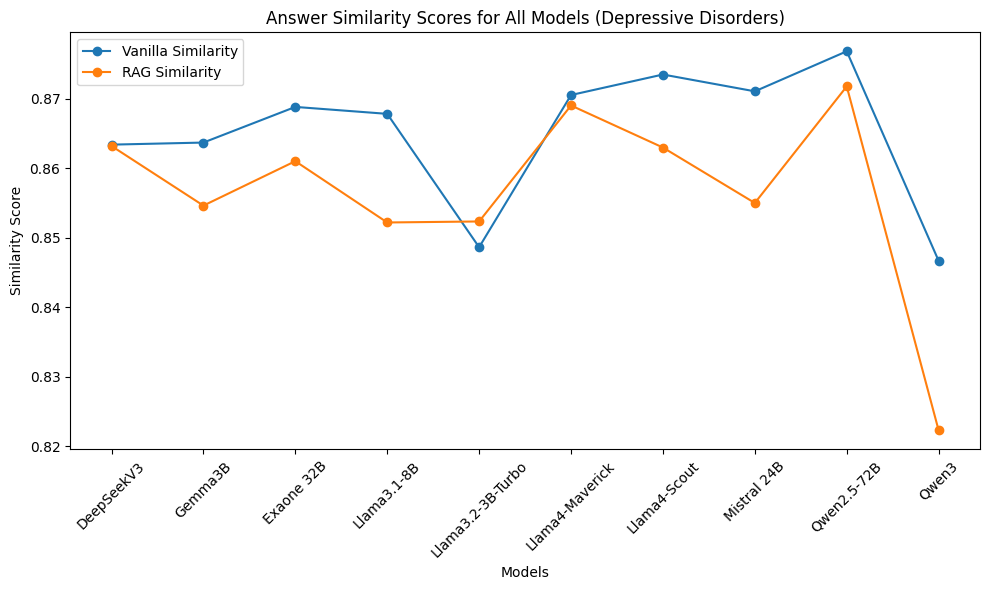

In [112]:
plot_answer_similarity_all_models("advanced_rag/results", category="Depressive Disorders")

In [113]:
def compare_overall_answer_relevancy_all_models(folder_path):
    results = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            # Calculate mean answer relevancy for vanilla and RAG
            vanilla_cols = [
                "answer_relevancy for Vanilla run 1",
                "answer_relevancy for Vanilla run 2",
                "answer_relevancy for Vanilla run 3"
            ]
            rag_cols = [
                "answer_relevancy for RAG run 1",
                "answer_relevancy for RAG run 2",
                "answer_relevancy for RAG run 3"
            ]
            for col in vanilla_cols:
                if col not in df.columns:
                    df[col] = np.nan
            for col in rag_cols:
                if col not in df.columns:
                    df[col] = np.nan
            df["Mean answer_relevancy for Vanilla"] = df[vanilla_cols].astype(float).mean(axis=1, skipna=True)
            df["Mean answer_relevancy for RAG"] = df[rag_cols].astype(float).mean(axis=1, skipna=True)
            # Drop rows with missing means
            df = df.dropna(subset=["Mean answer_relevancy for Vanilla", "Mean answer_relevancy for RAG"])
            vanilla_relevancy = df["Mean answer_relevancy for Vanilla"].values
            rag_relevancy = df["Mean answer_relevancy for RAG"].values
            # Calculate confidence intervals
            vanilla_ci = calculate_confidence_interval(vanilla_relevancy)
            rag_ci = calculate_confidence_interval(rag_relevancy)
            # Paired t-test
            t_stat, p_value = stats.ttest_rel(rag_relevancy, vanilla_relevancy)
            results.append({
                'Model': filename.replace('.json', ''),
                'Vanilla Mean Relevancy': vanilla_ci[0],
                'Vanilla 95% CI': f"[{vanilla_ci[1]:.4f} - {vanilla_ci[2]:.4f}]",
                'RAG Mean Relevancy': rag_ci[0],
                'RAG 95% CI': f"[{rag_ci[1]:.4f} - {rag_ci[2]:.4f}]",
                'Difference': rag_ci[0] - vanilla_ci[0],
                'P Value': p_value,
                'N Vanilla': len(vanilla_relevancy),
                'N RAG': len(rag_relevancy),
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    # Output results
    drop_cols = ['N Vanilla', 'N RAG']
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('Difference', ascending=False)
        results_df['P Value'] = results_df['P Value'].apply(lambda x: f"{x:.4f}")
        results_df = results_df.drop(columns=[col for col in drop_cols if col in results_df.columns])
        print("Overall Answer Relevancy Results:")
        display(results_df.reset_index(drop=True))

## RAGAS Answer Relevance  

The Answer Relevance metric evaluates to what extent the generated answer addresses the provided question. The answer is considered relevant if it directly addresses the question.    
* Step 1: Reverse-engineer ‘n’ variants of the question from the generated answer using a LLM (prompt: "Generate a question for the given answer.
answer: [answer])")  
* Step 2: Generate embedding for all the questions. Calculate the mean cosine similarity between the generated questions and the actual question.  

The Answer Relevance doesn't assess factual correctness of generated answer but rather penalises redundant or insufficient answers.  

Total API Calls by default: 4  
* 1 LLM call to generate the question based on the answer (by default - 3 question)  
* 1 embedding call for each generated question   (by default - 3) 
* 1 embedding call to embed the original question  

We set LLM temperature to 0.0 and still run evaluation 3 times. The metric is produced relatively fast still, but in such a fashion we diminish the influence of non-deterministic output. Sometimes all 3 evaluations have the same results and sometimes they are slightly different.  

Sources:  
* [RAGAS Documentation](https://docs.ragas.io/en/v0.1.21/concepts/metrics/answer_relevance.html)  
* [Original RAGAS paper](https://arxiv.org/abs/2309.15217)  

In [114]:
compare_overall_answer_relevancy_all_models("advanced_rag/results")  

Overall Answer Relevancy Results:


,Model,Vanilla Mean Relevancy,Vanilla 95% CI,RAG Mean Relevancy,RAG 95% CI,Difference,P Value,Significant
0,Qwen 2.5-72B-Instruct-Turbo,0.660793,[0.6509 - 0.6707],0.635795,[0.6191 - 0.6525],-0.024998,0.0081,Yes
1,LG AI ExaOne 3.5 32B Instruct,0.656375,[0.6412 - 0.6715],0.619774,[0.5986 - 0.6409],-0.036601,0.0028,Yes
2,Mistral Small 24B Instruct-2501,0.682126,[0.6729 - 0.6914],0.634967,[0.6157 - 0.6543],-0.047159,0.0000,Yes
3,DeepSeek V3,0.663984,[0.6556 - 0.6723],0.616694,[0.5979 - 0.6355],-0.047290,0.0000,Yes
4,Meta Llama 3.1 8B Instruct Turbo,0.689645,[0.6790 - 0.7003],0.636939,[0.6156 - 0.6583],-0.052706,0.0000,Yes
5,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.700357,[0.6910 - 0.7098],0.647161,[0.6292 - 0.6651],-0.053196,0.0000,Yes
6,Meta Llama 3.2 3B Instruct Turbo,0.639105,[0.6201 - 0.6581],0.570829,[0.5433 - 0.5983],-0.068276,0.0000,Yes
7,Meta Llama 4 Scout 17B-16E Instruct,0.690657,[0.6779 - 0.7034],0.620979,[0.5986 - 0.6433],-0.069678,0.0000,Yes
8,Google Gemma 3n E4B-it,0.681841,[0.6679 - 0.6958],0.579150,[0.5526 - 0.6057],-0.102691,0.0000,Yes
9,Qwen3 235B-A22B-fp8,0.729552,[0.7159 - 0.7432],0.608763,[0.5796 - 0.6379],-0.120789,0.0000,Yes


In [115]:
def plot_answer_relevancy_all_models(folder_path, category=None):
    results = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            # Prepare columns for relevancy
            vanilla_cols = [
                "answer_relevancy for Vanilla run 1",
                "answer_relevancy for Vanilla run 2",
                "answer_relevancy for Vanilla run 3"
            ]
            rag_cols = [
                "answer_relevancy for RAG run 1",
                "answer_relevancy for RAG run 2",
                "answer_relevancy for RAG run 3"
            ]
            for col in vanilla_cols:
                if col not in df.columns:
                    df[col] = np.nan
            for col in rag_cols:
                if col not in df.columns:
                    df[col] = np.nan
            df["Mean answer_relevancy for Vanilla"] = df[vanilla_cols].astype(float).mean(axis=1, skipna=True)
            df["Mean answer_relevancy for RAG"] = df[rag_cols].astype(float).mean(axis=1, skipna=True)
            if category is not None:
                df = df[df['psychiatric_category'] == category]
            if df.empty:
                continue
            vanilla_relevancy = df["Mean answer_relevancy for Vanilla"].mean()
            rag_relevancy = df["Mean answer_relevancy for RAG"].mean()
            results.append({
                'Model': filename.replace('.json', ''),
                'Vanilla Relevancy': vanilla_relevancy,
                'RAG Relevancy': rag_relevancy
            })
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    if not results:
        print(f"No data found for category: {category}")
        return

    results_df = pd.DataFrame(results)
    results_df.set_index('Model', inplace=True)

    short_names = {
        "DeepSeek V3": "DeepSeekV3",
        "Google Gemma 3n E4B-it": "Gemma3B",
        "LG AI ExaOne 3.5 32B Instruct": "Exaone 32B",
        "Meta Llama 3.1 8B Instruct Turbo": "Llama3.1-8B",
        "Meta Llama 4 Maverick 17B-128E-Instruct-FP8": "Llama4-Maverick",
        "Meta Llama 4 Scout 17B-16E Instruct": "Llama4-Scout",
        "Mistral Small 24B Instruct-2501": "Mistral 24B",
        "Qwen 2.5-72B-Instruct-Turbo": "Qwen2.5-72B",
        "Qwen3 235B-A22B-fp8": "Qwen3",
        "Meta Llama 3.1 8B Instruct Turbo": "Llama3.1-8B-Turbo"
    }

    results_df_plot = results_df.copy()
    results_df_plot['Short Model'] = results_df_plot.index.map(lambda x: short_names.get(x, x))

    plt.figure(figsize=(10, 6))
    plt.plot(results_df_plot['Short Model'], results_df_plot['Vanilla Relevancy'], marker='o', label='Vanilla Relevancy')
    plt.plot(results_df_plot['Short Model'], results_df_plot['RAG Relevancy'], marker='o', label='RAG Relevancy')
    title = "Answer Relevancy Scores for All Models"
    if category:
        title += f" ({category})"
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Relevancy Score')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

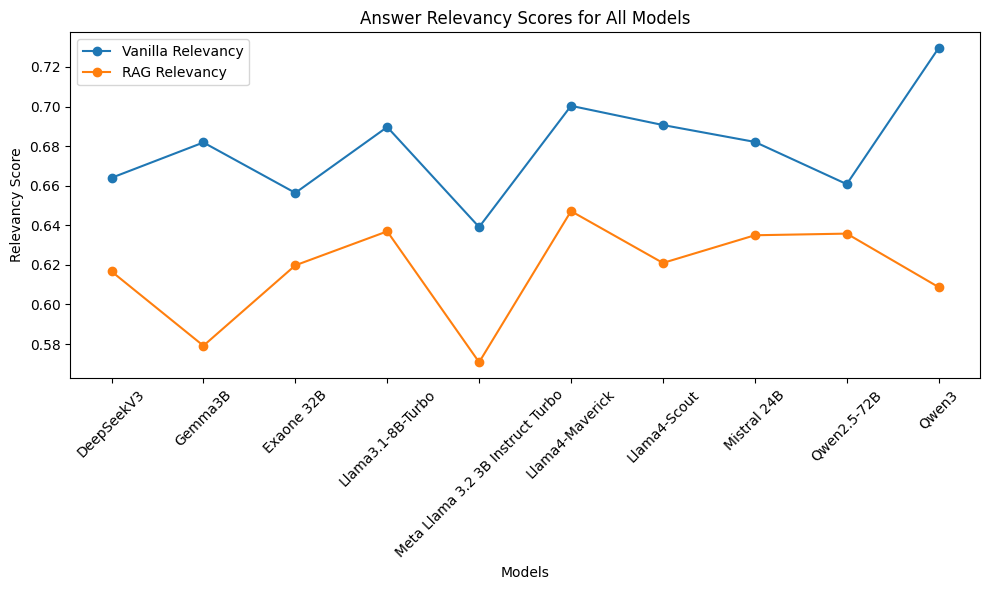

In [116]:
plot_answer_relevancy_all_models("advanced_rag/results")

In [117]:
def compare_relevancy_by_category(folder_path, categories):
    for category in categories:
        results = []
        for filename in os.listdir(folder_path):
            if not filename.endswith('.json'):
                continue
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                df = pd.DataFrame(data)
                df = df[df['psychiatric_category'] == category]
                vanilla_cols = [
                    "answer_relevancy for Vanilla run 1",
                    "answer_relevancy for Vanilla run 2",
                    "answer_relevancy for Vanilla run 3"
                ]
                rag_cols = [
                    "answer_relevancy for RAG run 1",
                    "answer_relevancy for RAG run 2",
                    "answer_relevancy for RAG run 3"
                ]
                for col in vanilla_cols:
                    if col not in df.columns:
                        df[col] = np.nan
                for col in rag_cols:
                    if col not in df.columns:
                        df[col] = np.nan
                df["Mean answer_relevancy for Vanilla"] = df[vanilla_cols].astype(float).mean(axis=1, skipna=True)
                df["Mean answer_relevancy for RAG"] = df[rag_cols].astype(float).mean(axis=1, skipna=True)
                df = df.dropna(subset=["Mean answer_relevancy for Vanilla", "Mean answer_relevancy for RAG"])
                vanilla_relevancy = df["Mean answer_relevancy for Vanilla"].values
                rag_relevancy = df["Mean answer_relevancy for RAG"].values
                if len(vanilla_relevancy) > 1 and len(rag_relevancy) > 1 and len(vanilla_relevancy) == len(rag_relevancy):
                    vanilla_ci = calculate_confidence_interval(vanilla_relevancy)
                    rag_ci = calculate_confidence_interval(rag_relevancy)
                    t_stat, p_value = stats.ttest_rel(rag_relevancy, vanilla_relevancy)
                    results.append({
                        'Model': filename.replace('.json', ''),
                        'Vanilla Mean Relevancy': vanilla_ci[0],
                        'Vanilla 95% CI': f"[{vanilla_ci[1]:.4f} - {vanilla_ci[2]:.4f}]",
                        'RAG Mean Relevancy': rag_ci[0],
                        'RAG 95% CI': f"[{rag_ci[1]:.4f} - {rag_ci[2]:.4f}]",
                        'Difference': rag_ci[0] - vanilla_ci[0],
                        'P Value': p_value,
                        'N Vanilla': len(vanilla_relevancy),
                        'N RAG': len(rag_relevancy),
                        'Significant': 'Yes' if p_value < 0.05 else 'No'
                    })
                else:
                    print(f"Insufficient data for category '{category}' in file {filename}. Skipping.")
            except Exception as e:
                print(f"Failed to process {filename}: {e}")

        drop_cols = ['N Vanilla', 'N RAG']
        if results:
            results_df = pd.DataFrame(results)
            results_df = results_df.sort_values('Difference', ascending=False)
            results_df['P Value'] = results_df['P Value'].apply(lambda x: f"{x:.4f}")
            results_df = results_df.drop(columns=[col for col in drop_cols if col in results_df.columns])
            print(f"Answer Relevancy Results for Category: {category}")
            display(results_df.reset_index(drop=True))

In [118]:
compare_relevancy_by_category('advanced_rag/results', categories)

Answer Relevancy Results for Category: Depressive Disorders


,Model,Vanilla Mean Relevancy,Vanilla 95% CI,RAG Mean Relevancy,RAG 95% CI,Difference,P Value,Significant
0,LG AI ExaOne 3.5 32B Instruct,0.681791,[0.6445 - 0.7191],0.656300,[0.6088 - 0.7038],-0.025491,0.3871,No
1,DeepSeek V3,0.680580,[0.6601 - 0.7011],0.644969,[0.5985 - 0.6914],-0.035611,0.1351,No
2,Mistral Small 24B Instruct-2501,0.704164,[0.6838 - 0.7245],0.665840,[0.6233 - 0.7083],-0.038324,0.1015,No
3,Meta Llama 4 Scout 17B-16E Instruct,0.707432,[0.6871 - 0.7278],0.666343,[0.6233 - 0.7094],-0.041089,0.0852,No
4,Meta Llama 3.1 8B Instruct Turbo,0.701569,[0.6807 - 0.7225],0.650641,[0.5982 - 0.7031],-0.050928,0.0861,No
5,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.713092,[0.6916 - 0.7346],0.647708,[0.5955 - 0.6999],-0.065384,0.0149,Yes
6,Meta Llama 3.2 3B Instruct Turbo,0.640830,[0.5930 - 0.6887],0.567412,[0.4959 - 0.6389],-0.073418,0.0937,No
7,Qwen 2.5-72B-Instruct-Turbo,0.687901,[0.6660 - 0.7098],0.603818,[0.5454 - 0.6622],-0.084083,0.0096,Yes
8,Google Gemma 3n E4B-it,0.686731,[0.6491 - 0.7244],0.558988,[0.4837 - 0.6343],-0.127743,0.0010,Yes
9,Qwen3 235B-A22B-fp8,0.757846,[0.7408 - 0.7749],0.627081,[0.5549 - 0.6993],-0.130766,0.0008,Yes


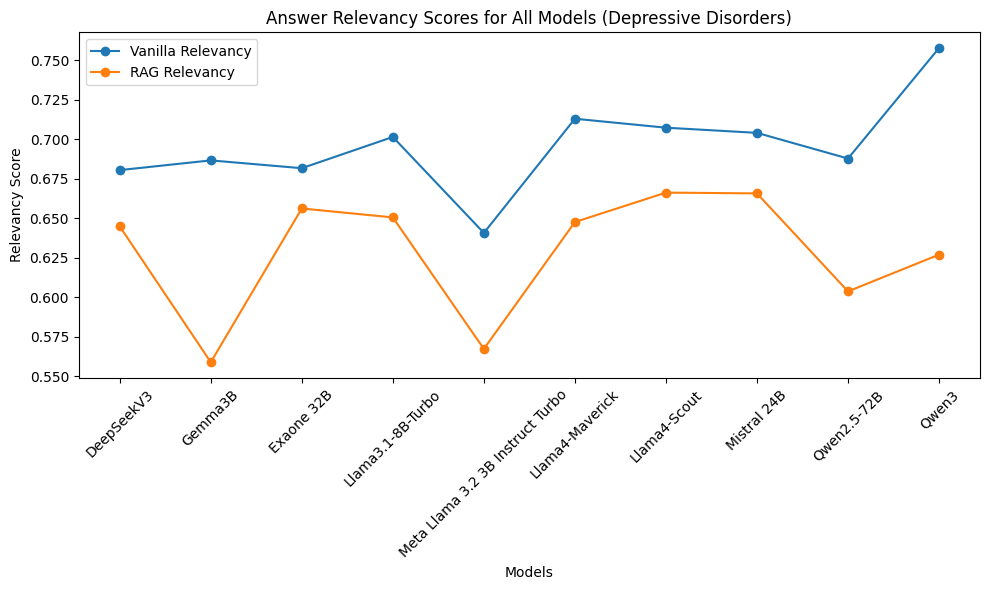

In [119]:
plot_answer_relevancy_all_models("advanced_rag/results", category="Depressive Disorders")

In [120]:
def compare_overall_rubric_score_all_models(folder_path):
    results = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)

            # Remove rows where either Vanilla or RAG rubric score is missing or empty
            df = df[~(df['Vanilla Rubric Score'].isna() | df['RAG Rubric Score'].isna())]
            df = df[(df['Vanilla Rubric Score'] != "") & (df['RAG Rubric Score'] != "")]
            # Extract rubric scores
            vanilla_rubric = df['Vanilla Rubric Score'].astype(float).values
            rag_rubric = df['RAG Rubric Score'].astype(float).values
            # Calculate confidence intervals
            vanilla_ci = calculate_confidence_interval(vanilla_rubric)
            rag_ci = calculate_confidence_interval(rag_rubric)
            # Paired t-test
            t_stat, p_value = stats.ttest_rel(rag_rubric, vanilla_rubric)
            results.append({
                'Model': filename.replace('.json', ''),
                'Vanilla Mean Rubric': vanilla_ci[0],
                'Vanilla 95% CI': f"[{vanilla_ci[1]:.4f} - {vanilla_ci[2]:.4f}]",
                'RAG Mean Rubric': rag_ci[0],
                'RAG 95% CI': f"[{rag_ci[1]:.4f} - {rag_ci[2]:.4f}]",
                'Difference': rag_ci[0] - vanilla_ci[0],
                'P Value': p_value,
                'N Vanilla': len(vanilla_rubric),
                'N RAG': len(rag_rubric),
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    # Output results
    drop_cols = ['N Vanilla', 'N RAG']
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('Difference', ascending=False)
        results_df['P Value'] = results_df['P Value'].apply(lambda x: f"{x:.4f}")
        results_df = results_df.drop(columns=[col for col in drop_cols if col in results_df.columns])
        print("Overall Rubric Score Results:")
        display(results_df.reset_index(drop=True))

### Rubric score 
* 1: "The answer is medically incorrect or contradicts established psychiatric knowledge; it does not address the question or ground truth at all."  
* 2: "The answer contains significant inaccuracies or omissions; it only partially addresses the question and differs notably from the ground truth."  
* 3: "The answer is generally correct but lacks important details or contains minor inaccuracies; it is somewhat aligned with the ground truth."  
* 4: "The answer is medically accurate, covers most relevant aspects, and closely matches the ground truth with only minor differences."  
* 5: "The answer is fully medically accurate, comprehensive, and matches the ground truth exactly in content and detail" 

In [121]:
compare_overall_rubric_score_all_models("advanced_rag/results")

Overall Rubric Score Results:


,Model,Vanilla Mean Rubric,Vanilla 95% CI,RAG Mean Rubric,RAG 95% CI,Difference,P Value,Significant
0,DeepSeek V3,4.073171,[3.9704 - 4.1760],4.089431,[3.9871 - 4.1918],0.01626,0.1576,No
1,LG AI ExaOne 3.5 32B Instruct,3.588076,[3.4742 - 3.7020],3.604336,[3.4916 - 3.7171],0.01626,0.2211,No
2,Qwen 2.5-72B-Instruct-Turbo,3.815718,[3.7091 - 3.9224],3.821138,[3.7139 - 3.9284],0.00542,0.6837,No
3,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,3.888889,[3.7922 - 3.9856],3.891599,[3.7941 - 3.9891],0.00271,0.8530,No
4,Meta Llama 4 Scout 17B-16E Instruct,3.826558,[3.7269 - 3.9262],3.823848,[3.7249 - 3.9228],-0.00271,0.8352,No
5,Meta Llama 3.2 3B Instruct Turbo,3.005420,[2.8910 - 3.1199],3.000000,[2.8843 - 3.1157],-0.00542,0.6954,No
6,Google Gemma 3n E4B-it,3.411924,[3.3032 - 3.5207],3.403794,[3.2954 - 3.5122],-0.00813,0.5492,No
7,Qwen3 235B-A22B-fp8,3.956640,[3.8646 - 4.0487],3.943089,[3.8516 - 4.0346],-0.01355,0.4241,No
8,Meta Llama 3.1 8B Instruct Turbo,3.271003,[3.1626 - 3.3794],3.254743,[3.1446 - 3.3649],-0.01626,0.2398,No
9,Mistral Small 24B Instruct-2501,3.685637,[3.5756 - 3.7957],3.661247,[3.5521 - 3.7704],-0.02439,0.0718,No


In [122]:
def compare_rubric_score_by_category(folder_path, categories):
    for category in categories:
        results = []
        for filename in os.listdir(folder_path):
            if not filename.endswith('.json'):
                continue
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                df = pd.DataFrame(data)
                # Remove rows where either Vanilla or RAG rubric score is missing or empty
                df = df[~(df['Vanilla Rubric Score'].isna() | df['RAG Rubric Score'].isna())]
                df = df[(df['Vanilla Rubric Score'] != "") & (df['RAG Rubric Score'] != "")]
                df = df[df['psychiatric_category'] == category]
                if 'Vanilla Rubric Score' not in df.columns or 'RAG Rubric Score' not in df.columns:
                    print(f"Missing rubric score columns in {filename}. Skipping.")
                    continue
                vanilla_rubric = df['Vanilla Rubric Score'].astype(float).values
                rag_rubric = df['RAG Rubric Score'].astype(float).values
                if len(vanilla_rubric) > 1 and len(rag_rubric) > 1 and len(vanilla_rubric) == len(rag_rubric):
                    vanilla_ci = calculate_confidence_interval(vanilla_rubric)
                    rag_ci = calculate_confidence_interval(rag_rubric)
                    t_stat, p_value = stats.ttest_rel(rag_rubric, vanilla_rubric)
                    results.append({
                        'Model': filename.replace('.json', ''),
                        'Vanilla Mean Rubric': vanilla_ci[0],
                        'Vanilla 95% CI': f"[{vanilla_ci[1]:.4f} - {vanilla_ci[2]:.4f}]",
                        'RAG Mean Rubric': rag_ci[0],
                        'RAG 95% CI': f"[{rag_ci[1]:.4f} - {rag_ci[2]:.4f}]",
                        'Difference': rag_ci[0] - vanilla_ci[0],
                        'P Value': p_value,
                        'N Vanilla': len(vanilla_rubric),
                        'N RAG': len(rag_rubric),
                        'Significant': 'Yes' if p_value < 0.05 else 'No'
                    })
                else:
                    print(f"Insufficient data for category '{category}' in file {filename}. Skipping.")
            except Exception as e:
                print(f"Failed to process {filename}: {e}")

        drop_cols = ['N Vanilla', 'N RAG']
        if results:
            results_df = pd.DataFrame(results)
            results_df = results_df.sort_values('Difference', ascending=False)
            results_df['P Value'] = results_df['P Value'].apply(lambda x: f"{x:.4f}")
            results_df = results_df.drop(columns=[col for col in drop_cols if col in results_df.columns])
            print(f"Rubric Score Results for Category: {category}")
            display(results_df.reset_index(drop=True))

In [123]:
compare_rubric_score_by_category('advanced_rag/results', categories)

Rubric Score Results for Category: Depressive Disorders


,Model,Vanilla Mean Rubric,Vanilla 95% CI,RAG Mean Rubric,RAG 95% CI,Difference,P Value,Significant
0,Qwen3 235B-A22B-fp8,3.903226,[3.6841 - 4.1224],3.951613,[3.7542 - 4.1490],0.048387,0.1818,No
1,DeepSeek V3,4.177419,[3.9276 - 4.4273],4.209677,[3.9658 - 4.4536],0.032258,0.1590,No
2,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,3.854839,[3.6166 - 4.0931],3.887097,[3.6390 - 4.1352],0.032258,0.4187,No
3,Google Gemma 3n E4B-it,3.258065,[3.0107 - 3.5054],3.274194,[3.0301 - 3.5183],0.016129,0.6584,No
4,LG AI ExaOne 3.5 32B Instruct,3.564516,[3.2608 - 3.8682],3.580645,[3.2842 - 3.8770],0.016129,0.3213,No
5,Meta Llama 3.2 3B Instruct Turbo,3.193548,[2.9300 - 3.4571],3.193548,[2.9300 - 3.4571],0.000000,1.0000,No
6,Qwen 2.5-72B-Instruct-Turbo,3.919355,[3.6621 - 4.1766],3.919355,[3.6462 - 4.1926],0.000000,1.0000,No
7,Mistral Small 24B Instruct-2501,3.677419,[3.4063 - 3.9486],3.661290,[3.4139 - 3.9087],-0.016129,0.7087,No
8,Meta Llama 4 Scout 17B-16E Instruct,3.790323,[3.5508 - 4.0299],3.758065,[3.5343 - 3.9819],-0.032258,0.3213,No
9,Meta Llama 3.1 8B Instruct Turbo,3.322581,[3.0634 - 3.5818],3.225806,[2.9600 - 3.4916],-0.096774,0.0131,Yes


In [124]:
from scipy.stats import ttest_rel

file_path = "advanced_rag/results/Google Gemma 3n E4B-it.json"
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)
df = pd.DataFrame(data)

# Assuming df['Vanilla Rubric Score'] and df['RAG Rubric Score'] are already floats and aligned
t_stat, p_value = ttest_rel(df['RAG Rubric Score'], df['Vanilla Rubric Score'])
print("t_stat:", t_stat)
print("p_value:", p_value)

print("Any NaN in Vanilla?", df['Vanilla Rubric Score'].isna().any())
print("Any NaN in RAG?", df['RAG Rubric Score'].isna().any())
print("All differences zero?", np.allclose(df['RAG Rubric Score'], df['Vanilla Rubric Score']))

t_stat: -0.59947894041409
p_value: 0.5492224477548315
Any NaN in Vanilla? False
Any NaN in RAG? False
All differences zero? False


The nan in the result by category means that the rubric scores for vanilla and RAG are exatcly the same for every sample. p_value: nan means "no difference to test". If all paired values are numerically equal, you get a p-value of 1.

In [125]:
def summarize_rag_metric_all_questions(folder_path, metric_prefix):
    """
    Summarize a RAG-only metric (e.g., faithfulness, context precision) for all questions and models.

    Args:
        folder_path (str): Path to results folder.
        metric_prefix (str): Prefix for metric columns, e.g. "faithfulness" or "context_precision".
    """
    results = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            metric_cols = [
                f"{metric_prefix} for RAG run 1",
                f"{metric_prefix} for RAG run 2",
                f"{metric_prefix} for RAG run 3"
            ]
            for col in metric_cols:
                if col not in df.columns:
                    df[col] = np.nan
            df[f"Mean {metric_prefix} for RAG"] = df[metric_cols].astype(float).mean(axis=1, skipna=True)
            metric_values = df[f"Mean {metric_prefix} for RAG"].dropna().values
            if len(metric_values) > 1:
                mean, lower, upper, margin = calculate_confidence_interval(metric_values)
                results.append({
                    'Model': filename.replace('.json', ''),
                    f'Mean {metric_prefix}': mean,
                    '95% CI': f"[{lower:.4f} - {upper:.4f}]",
                    'N': len(metric_values)
                })
            else:
                print(f"Insufficient {metric_prefix} data in {filename}. Skipping.")
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    drop_cols = ['N']
    if results:
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values(f'Mean {metric_prefix}', ascending=False)
        results_df = results_df.drop(columns=[col for col in drop_cols if col in results_df.columns])
        print(f"{metric_prefix.capitalize()} (RAG only) Results for ALL questions:")
        display(results_df.reset_index(drop=True))

# RAG Metrics  
## RAGAS Faithfulness 

Definition:  
Faithfulness or groundness is sometimes used interchangeably.  

The process:  
Faithfulness measures the factual consistency of the generated answer against the given context. It is calculated from the answer and the retrieved context. The answer is scaled to the (0, 1) range. The higher the better. A low faithfulness metric indicates that the language model outputs response without correct utilisation of provided context or doesn't find any relevant passages in it.   
The generated answer is regarded as faithful if all the claims made in the answer can be inferred from the given context.  
* At the first step, the generated answer is broken down into individual statements.     
* At the next step, each of these claims is cross-checked with the given context to determine if it can be inferred from the context.    
* The final score is calculated by dividing the number of claims that can be inferred from the context by the total number of claims in the generated response.    

We set LLM temperature to 0.0 and still run evaluation 3 times. The metric is produced relatively fast still, but in such a fashion we diminish the influence of non-deterministic output. Sometimes all 3 evaluations have the same results and sometimes they are slightly different.  

Source:  
* [RAGAS Docs for Faitfulness](https://docs.ragas.io/en/v0.1.21/concepts/metrics/faithfulness.html)   
* [Microsoft Learn End-to-end LLM evaluation](https://learn.microsoft.com/en-us/azure/architecture/ai-ml/guide/rag/rag-llm-evaluation-phase)  


In [126]:
summarize_rag_metric_all_questions("advanced_rag/results", "faithfulness")

Faithfulness (RAG only) Results for ALL questions:


,Model,Mean faithfulness,95% CI
0,Google Gemma 3n E4B-it,0.507717,[0.4813 - 0.5342]
1,Mistral Small 24B Instruct-2501,0.482203,[0.4532 - 0.5112]
2,Meta Llama 3.2 3B Instruct Turbo,0.462384,[0.4340 - 0.4908]
3,LG AI ExaOne 3.5 32B Instruct,0.457730,[0.4308 - 0.4847]
4,Qwen3 235B-A22B-fp8,0.454512,[0.4269 - 0.4821]
5,Meta Llama 4 Scout 17B-16E Instruct,0.448019,[0.4201 - 0.4759]
6,DeepSeek V3,0.440876,[0.4138 - 0.4680]
7,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.425066,[0.3956 - 0.4546]
8,Qwen 2.5-72B-Instruct-Turbo,0.421771,[0.3928 - 0.4507]
9,Meta Llama 3.1 8B Instruct Turbo,0.398434,[0.3725 - 0.4243]


In [127]:
def summarize_rag_metric_by_category(folder_path, categories, metric_prefix):
    """
    Summarize a RAG-only metric (e.g., faithfulness, context precision) by category and model.
    
    Args:
        folder_path (str): Path to results folder.
        categories (list): List of psychiatric categories.
        metric_prefix (str): Prefix for metric columns, e.g. "faithfulness" or "context_precision".
    """
    for category in categories:
        results = []
        for filename in os.listdir(folder_path):
            if not filename.endswith('.json'):
                continue
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                df = pd.DataFrame(data)
                df = df[df['psychiatric_category'] == category]
                metric_cols = [
                    f"{metric_prefix} for RAG run 1",
                    f"{metric_prefix} for RAG run 2",
                    f"{metric_prefix} for RAG run 3"
                ]
                for col in metric_cols:
                    if col not in df.columns:
                        df[col] = np.nan
                df[f"Mean {metric_prefix} for RAG"] = df[metric_cols].astype(float).mean(axis=1, skipna=True)
                metric_values = df[f"Mean {metric_prefix} for RAG"].dropna().values
                if len(metric_values) > 1:
                    mean, lower, upper, margin = calculate_confidence_interval(metric_values)
                    results.append({
                        'Model': filename.replace('.json', ''),
                        f'Mean {metric_prefix}': mean,
                        '95% CI': f"[{lower:.4f} - {upper:.4f}]",
                        'N': len(metric_values)
                    })
                else:
                    print(f"Insufficient {metric_prefix} data for category '{category}' in {filename}. Skipping.")
            except Exception as e:
                print(f"Failed to process {filename}: {e}")


        # Output results
        drop_cols = ['N']

        if results:
            results_df = pd.DataFrame(results)
            results_df = results_df.sort_values(f'Mean {metric_prefix}', ascending=False)
            results_df = results_df.drop(columns=[col for col in drop_cols if col in results_df.columns])
            print(f"{metric_prefix.capitalize()} (RAG only) Results for Category: {category}")
            display(results_df.reset_index(drop=True))



In [128]:
def plot_rag_metric_all_models(folder_path, metric_prefix, category=None):
    """
    Plot a RAG-only metric (e.g., faithfulness, context_precision, context_recall) for all models.
    Args:
        folder_path (str): Path to results folder.
        metric_prefix (str): Prefix for metric columns, e.g. "faithfulness" or "context_precision".
        category (str or None): Psychiatric category to filter by (optional).
    """
    results = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            if category is not None:
                df = df[df['psychiatric_category'] == category]
            metric_cols = [
                f"{metric_prefix} for RAG run 1",
                f"{metric_prefix} for RAG run 2",
                f"{metric_prefix} for RAG run 3"
            ]
            for col in metric_cols:
                if col not in df.columns:
                    df[col] = np.nan
            df[f"Mean {metric_prefix} for RAG"] = df[metric_cols].astype(float).mean(axis=1, skipna=True)
            metric_values = df[f"Mean {metric_prefix} for RAG"].dropna().values
            if len(metric_values) > 0:
                results.append({
                    'Model': filename.replace('.json', ''),
                    f'Mean {metric_prefix}': metric_values.mean()
                })
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    if not results:
        print(f"No data found for metric '{metric_prefix}' and category: {category}")
        return

    results_df = pd.DataFrame(results)
    results_df.set_index('Model', inplace=True)

    short_names = {
        "DeepSeek V3": "DeepSeekV3",
        "Google Gemma 3n E4B-it": "Gemma3B",
        "LG AI ExaOne 3.5 32B Instruct": "Exaone 32B",
        "Meta Llama 3.1 8B Instruct Turbo": "Llama3.1-8B",
        "Meta Llama 4 Maverick 17B-128E-Instruct-FP8": "Llama4-Maverick",
        "Meta Llama 4 Scout 17B-16E Instruct": "Llama4-Scout",
        "Mistral Small 24B Instruct-2501": "Mistral 24B",
        "Qwen 2.5-72B-Instruct-Turbo": "Qwen2.5-72B",
        "Qwen3 235B-A22B-fp8": "Qwen3"
    }

    results_df['Short Model'] = results_df.index.map(lambda x: short_names.get(x, x))

    plt.figure(figsize=(10, 6))
    plt.plot(results_df['Short Model'], results_df[f'Mean {metric_prefix}'], marker='o', label=f'RAG {metric_prefix.capitalize()}')
    title = f"{metric_prefix.capitalize()} (RAG only) Scores for All Models"
    if category:
        title += f" ({category})"
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel(f'{metric_prefix.capitalize()} Score')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

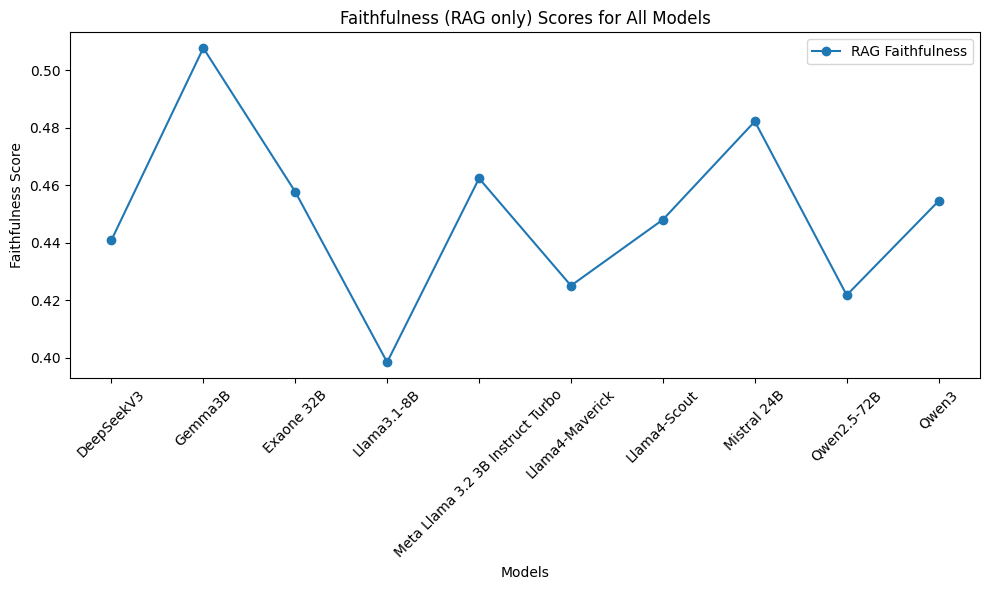

In [129]:
plot_rag_metric_all_models("advanced_rag/results", "faithfulness")

In [130]:
summarize_rag_metric_by_category("advanced_rag/results", categories, "faithfulness")

Faithfulness (RAG only) Results for Category: Depressive Disorders


,Model,Mean faithfulness,95% CI
0,Mistral Small 24B Instruct-2501,0.549821,[0.4795 - 0.6202]
1,Meta Llama 4 Scout 17B-16E Instruct,0.546656,[0.4832 - 0.6101]
2,Google Gemma 3n E4B-it,0.531316,[0.4636 - 0.5990]
3,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.523980,[0.4476 - 0.6003]
4,LG AI ExaOne 3.5 32B Instruct,0.503866,[0.4479 - 0.5599]
5,DeepSeek V3,0.498197,[0.4353 - 0.5611]
6,Meta Llama 3.2 3B Instruct Turbo,0.486309,[0.4257 - 0.5469]
7,Qwen3 235B-A22B-fp8,0.484437,[0.4256 - 0.5433]
8,Meta Llama 3.1 8B Instruct Turbo,0.435596,[0.3701 - 0.5011]
9,Qwen 2.5-72B-Instruct-Turbo,0.432096,[0.3653 - 0.4989]


### Context Recall

In [131]:
summarize_rag_metric_all_questions("advanced_rag/results", "context_recall")

Context_recall (RAG only) Results for ALL questions:


,Model,Mean context_recall,95% CI
0,Qwen 2.5-72B-Instruct-Turbo,0.592857,[0.3744 - 0.8113]
1,Meta Llama 4 Scout 17B-16E Instruct,0.400265,[0.3639 - 0.4366]
2,DeepSeek V3,0.396115,[0.3603 - 0.4320]
3,Mistral Small 24B Instruct-2501,0.386665,[0.3516 - 0.4217]
4,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.377902,[0.3422 - 0.4136]
5,Qwen3 235B-A22B-fp8,0.365803,[0.3287 - 0.4029]
6,LG AI ExaOne 3.5 32B Instruct,0.354050,[0.3182 - 0.3899]
7,Meta Llama 3.1 8B Instruct Turbo,0.347496,[0.3116 - 0.3834]
8,Meta Llama 3.2 3B Instruct Turbo,0.339332,[0.3045 - 0.3742]
9,Google Gemma 3n E4B-it,0.313069,[0.2790 - 0.3471]


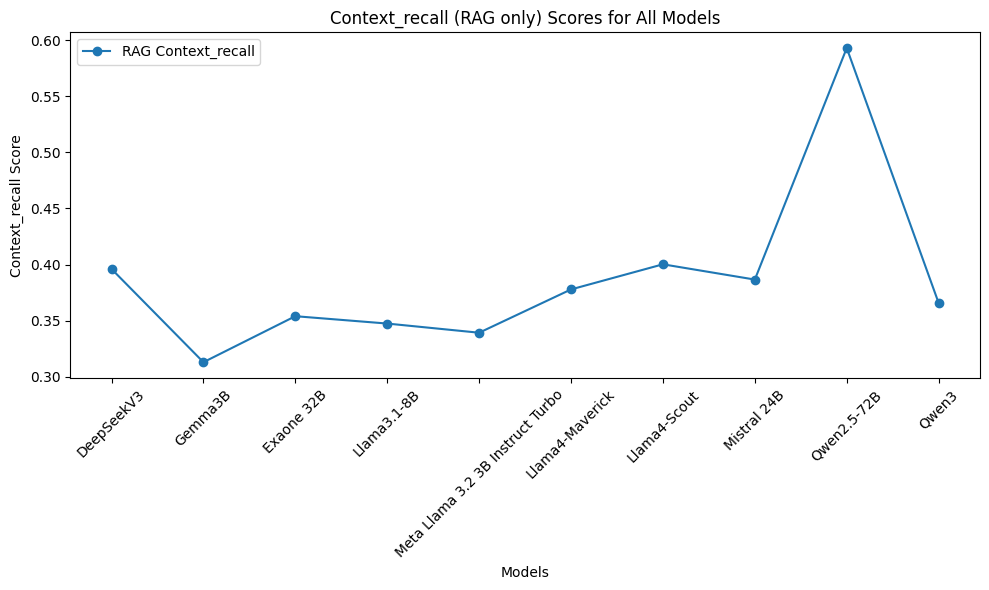

In [132]:
plot_rag_metric_all_models("advanced_rag/results", "context_recall")

### Context Precision

In [133]:
summarize_rag_metric_all_questions("advanced_rag/results", "context_precision")

Context_precision (RAG only) Results for ALL questions:


,Model,Mean context_precision,95% CI
0,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.464845,[0.4198 - 0.5099]
1,Qwen 2.5-72B-Instruct-Turbo,0.462285,[0.4166 - 0.5080]
2,DeepSeek V3,0.458336,[0.4152 - 0.5015]
3,Qwen3 235B-A22B-fp8,0.458311,[0.4126 - 0.5041]
4,Meta Llama 4 Scout 17B-16E Instruct,0.456539,[0.4132 - 0.4999]
5,Mistral Small 24B Instruct-2501,0.436681,[0.3930 - 0.4804]
6,Meta Llama 3.1 8B Instruct Turbo,0.357249,[0.3162 - 0.3983]
7,LG AI ExaOne 3.5 32B Instruct,0.353935,[0.3118 - 0.3960]
8,Google Gemma 3n E4B-it,0.299759,[0.2606 - 0.3390]
9,Meta Llama 3.2 3B Instruct Turbo,0.289189,[0.2508 - 0.3276]


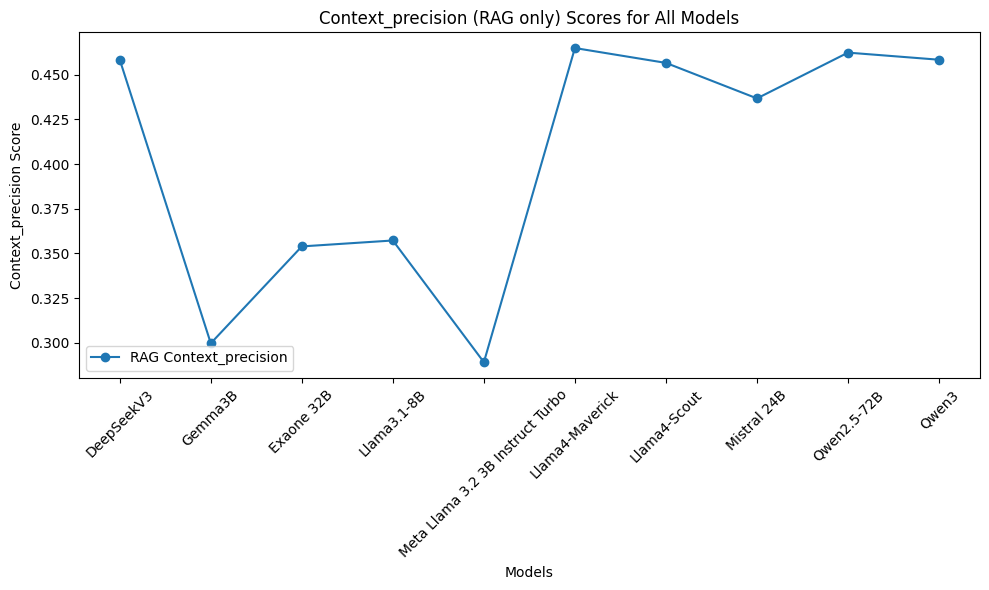

In [134]:
plot_rag_metric_all_models("advanced_rag/results", "context_precision")

In [135]:
summarize_rag_metric_by_category("advanced_rag/results", categories, "context_precision")

Context_precision (RAG only) Results for Category: Depressive Disorders


,Model,Mean context_precision,95% CI
0,Meta Llama 4 Scout 17B-16E Instruct,0.492832,[0.3815 - 0.6042]
1,Meta Llama 4 Maverick 17B-128E-Instruct-FP8,0.477599,[0.3697 - 0.5855]
2,DeepSeek V3,0.462664,[0.3455 - 0.5798]
3,Qwen 2.5-72B-Instruct-Turbo,0.448029,[0.3303 - 0.5658]
4,Mistral Small 24B Instruct-2501,0.446983,[0.3357 - 0.5583]
5,Qwen3 235B-A22B-fp8,0.443548,[0.3242 - 0.5629]
6,LG AI ExaOne 3.5 32B Instruct,0.365143,[0.2549 - 0.4754]
7,Meta Llama 3.1 8B Instruct Turbo,0.351731,[0.2470 - 0.4565]
8,Google Gemma 3n E4B-it,0.306153,[0.2035 - 0.4088]
9,Meta Llama 3.2 3B Instruct Turbo,0.280869,[0.1860 - 0.3757]
